# Исходный датасет
Вам необходимо сгенерировать свой датасет или выбрать любой публичный датасет имеющий
- не менее 100 млн записей. Если не получается сделать расчеты на таком объеме - можно уменьшить размер.
- имеющий колонки различных типов данных - numeric, datetime (range в несколько лет), string.
- достаточно минимального набора колонок, чтобы датафайл был не сильно большой.
- имеющий не менее 10% дублей (допускается добавить их самостоятельно)
- хранящийся в csv / json формате в файле на диске или по url

In [73]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
import string

In [74]:
# Задаем параметры

n_rows = 10_000_000
duplicate_ratio = 0.1  # 10% дублей

In [75]:
# Генерация данных

def generate_random_string(length=10): 
    return ''.join(random.choice(string.ascii_lowercase + string.digits) for i in range(length))

numeric_data = np.random.randint(1, 100, n_rows)
datetime_data = [datetime(2022, 1, 1) + timedelta(days=np.random.randint(0, 365 * 2)
                                                  , seconds=np.random.randint(0, 86400)) for _ in range(n_rows)]
string_data = [generate_random_string() for _ in range(n_rows)]

In [76]:
# Создание DataFrame

df = pd.DataFrame({
    'numeric': numeric_data,
    'datetime': datetime_data,
    'string': string_data
})

In [77]:
# Добавление дублей

n_duplicates = int(n_rows * duplicate_ratio)
df_duplicates = df.sample(n=n_duplicates, replace=True)
df = pd.concat([df, df_duplicates])

In [78]:
# Сохранение в CSV

df.to_csv('large_dataset.csv', index=False)
print("Dataset generated and saved to 'large_dataset.csv'")

Dataset generated and saved to 'large_dataset.csv'


In [79]:
df

,numeric,datetime,string
0,33,2022-01-18 07:09:08,hnag7d8sy9
1,44,2023-09-20 10:09:17,s5zyh2ba3z
2,34,2023-06-10 08:54:35,p1pem2l0t3
3,38,2023-05-24 01:22:53,bp0xram6sh
4,29,2022-03-07 12:39:29,jd70n8evr9
...,...,...,...
9759838,12,2023-03-03 14:32:24,nb2yh3may9
8597412,94,2023-08-23 15:39:32,lq02m1dorn
3292899,34,2022-09-19 01:28:16,wsirv9uhgu
6716009,74,2023-09-22 09:05:16,16o7bddm1x


# Считывание и процессинг
Считываем файл или тянем данные по ссылке и далее процессим данные
- удалить пустые / na строки
- удалить дубли
- строки в которых нет цифр превратить в пустые
- удалить записи в промежутке от 1 до 3 часов ночи

Для ускорения выполнения распараллеливайте выполнение этих шагов


In [80]:
import re
from joblib import Parallel, delayed, cpu_count

In [81]:
# Функция для считывания данных

def read_data(file_path):
    return pd.read_csv(file_path)

In [82]:
# Функция для удаления пустых / na строк

def drop_na(df):
    return df.dropna()

In [83]:
# Функция для удаления дублированных строк

def drop_duplicates(df):
    return df.drop_duplicates()

In [84]:
# Функция для преобразования строк без цифр в пустые

def convert_non_numeric_strings(df):
    df['string'] = df['string'].apply(lambda x: '' if not re.search(r'\d', x) else x)
    return df

In [85]:
# Функция для удаления записей в промежутке от 1 до 3 часов ночи
def remove_night_rows(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df[~((df['datetime'].dt.hour >= 1) & (df['datetime'].dt.hour < 3))]

In [86]:
# Функция для параллельной обработки с использованием Joblib

def parallel_process(data, func):
    n_cores = cpu_count()
    data_split = np.array_split(data, n_cores)
    processed_splits = Parallel(n_jobs=n_cores)(delayed(func)(split) for split in data_split)
    return pd.concat(processed_splits)

In [87]:
# Основной процесс

def process_data(file_path):
    # Шаг 1: Считывание данных
    df = read_data(file_path)

    # Шаг 2: Удаление пустых / na строк
    df = parallel_process(df, drop_na)

    # Шаг 3: Удаление дублированных строк
    df = parallel_process(df, drop_duplicates)

    # Шаг 4: Преобразование строк без цифр в пустые
    df = parallel_process(df, convert_non_numeric_strings)

    # Шаг 5: Удаление записей в промежутке от 1 до 3 часов ночи
    df = parallel_process(df, remove_night_rows)

    return df

In [88]:
# Загрузка и процессинг данных

file_path = 'large_dataset.csv'
processed_data = process_data(file_path)
print("Data processing completed")

Data processing completed


In [89]:
processed_data

,numeric,datetime,string
0,33,2022-01-18 07:09:08,hnag7d8sy9
1,44,2023-09-20 10:09:17,s5zyh2ba3z
2,34,2023-06-10 08:54:35,p1pem2l0t3
4,29,2022-03-07 12:39:29,jd70n8evr9
5,44,2023-08-21 10:46:40,
...,...,...,...
10999994,77,2022-12-02 00:04:32,vql0uvdd92
10999995,12,2023-03-03 14:32:24,nb2yh3may9
10999996,94,2023-08-23 15:39:32,lq02m1dorn
10999998,74,2023-09-22 09:05:16,16o7bddm1x


# Расчет метрик
Агрегация по времени, для каждого часа рассчитать
- кол-во уникальных string
- среднее и медиану для numeric

Так же напишите SQL запрос для выполнения подобных расчетов напрямую в базе данных. Можно его вставить в код в виде комментария.


In [90]:
processed_data['datetime'] = pd.to_datetime(processed_data['datetime'])
processed_data['hour'] = processed_data['datetime'].dt.hour

In [91]:
result = processed_data.groupby('hour') \
                        .agg(
                            unique_strings=('string', pd.Series.nunique),
                            mean_numeric=('numeric', 'mean'),
                            median_numeric=('numeric', 'median'))

In [24]:
# Эквивалентный SQL запрос для выполнения подобных расчетов напрямую в базе данных:
import sqlite3

# Подключаемся к SQLite базе данных (создаем временную базу данных в памяти)
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Сохраняем датафрейм в таблицу SQLite
processed_data.to_sql('processed_data', conn, index=False, if_exists='replace')

query = """
select 
    extract(hour from datetime) as hour,
    count(distinct string) as unique_strings,
    avg(numeric) as mean_numeric,
    percentile_cont(0.5) within group (order by numeric) as median_numeric
from processed_data
group by extract(hour from datetime)
order by hour
"""
pd.read_sql_query(query, conn)

# Закрываем соединение с базой данных
conn.close()

10048765

# Мерж с метриками
К каждой строке в исходном датасете примержить метрики ближайшего часа рассчитанные в предыдущем шаге


In [92]:
data = processed_data.merge(result, left_on = processed_data.hour, right_index = True)
del data['key_0']

# Аналитические метрики
Для колонки numeric по полному датасету построить
- Гистограмму
- 95% доверительный интервал, с комментарием как выбирали методику расчета

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

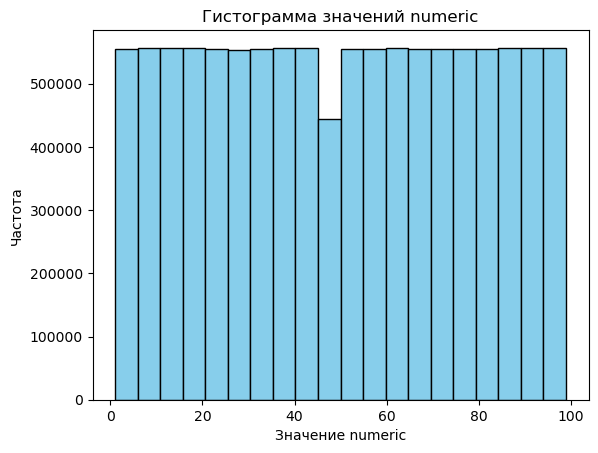

In [94]:
# Гистограмма
plt.hist(df['numeric'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Значение numeric')
plt.ylabel('Частота')
plt.title('Гистограмма значений numeric')
plt.show()

In [95]:
# Комментарий к методике расчета
# Для равномерного распределения, где среднее значение вычисляется как 
# среднее арифметическое между минимальным и максимальным значениями, а стандартное отклонение равно
# половине разности между максимальным и минимальным значениями, 
# мы можем использовать формулу для равномерного распределения для расчета 95% доверительного интервала:

# Функция для расчета 95% доверительного интервала для равномерного распределения
def uniform_ci(df):
    a = np.min(df)
    b = np.max(df)
    mu = (a + b) / 2
    sigma = (b - a) / np.sqrt(12)
    n = len(df) #размер выборки
    margin_of_error = 1.96 * (sigma / np.sqrt(n))
    lower_bound = mu - margin_of_error
    upper_bound = mu + margin_of_error
    return lower_bound, upper_bound

# Преобразование данных в массив NumPy
numeric_data = df['numeric'].values

# Вызов функции для расчета доверительного интервала
lower_bound, upper_bound = uniform_ci(numeric_data)
print(f'95% доверительный интервал для равномерного распределения: [{lower_bound}, {upper_bound}]')

95% доверительный интервал для равномерного распределения: [49.983281581922014, 50.016718418077986]


# Визуализация
1.	Отрисовать график среднего значения numeric колонки (y) по месяцам (x).
2.	Heatmap по частотности символов в колонке string


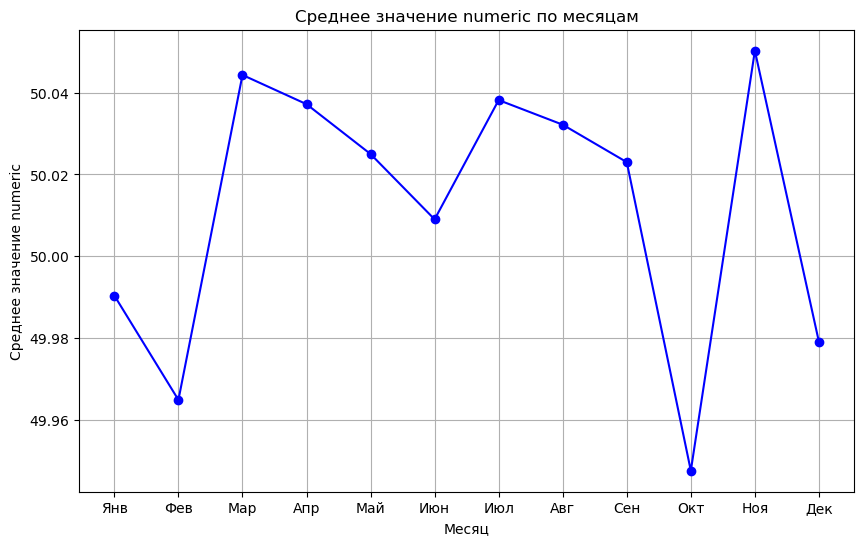

In [96]:
# Извлечение месяца из столбца datetime
data['month'] = data['datetime'].dt.month

# Группировка данных по месяцу и вычисление среднего значения numeric
mean_numeric_by_month = data.groupby('month')['numeric'].mean()

# Построение графика среднего значения numeric по месяцам
plt.figure(figsize=(10, 6))
mean_numeric_by_month.plot(marker='o', color='b')
plt.xlabel('Месяц')
plt.ylabel('Среднее значение numeric')
plt.title('Среднее значение numeric по месяцам')
plt.xticks(range(1, 13), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(True)
plt.show()

# Доп. задание
1. Случайно поделить датасет на 3 части - в одной 25% записей, во второй 25% и 50% в третьей.
2. Проверить на статистическую значимость различий для среднего по колонке numeric
3. Оценить силу эффекта
4. Проделать шаги 2 и 3 используя баесовский подход
5. Кратко описать как выбирали методы расчета


In [97]:
#Классический подход
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Разделение датасета на три части (25%, 25%, 50%)
df_part1 = df.sample(frac=0.25)
df = df.drop(df_part1.index)
df_part2 = df.sample(frac=0.25)
df_part3 = df.drop(df_part2.index)

# Вычисление средних значений numeric
mean_numeric_part1 = df_part1['numeric'].mean()
mean_numeric_part2 = df_part2['numeric'].mean()
mean_numeric_part3 = df_part3['numeric'].mean()

# Проверка статистической значимости средних значений
t_statistic, p_value = ttest_ind(df_part1['numeric'], df_part2['numeric'])
if p_value < 0.05:
    print("Различия между первым и вторым сегментами статистически значимы.")
else:
    print("Различия между первым и вторым сегментами не являются статистически значимыми.")

t_statistic, p_value = ttest_ind(df_part1['numeric'], df_part3['numeric'])
if p_value < 0.05:
    print("Различия между первым и третьим сегментами статистически значимы.")
else:
    print("Различия между первым и третьим сегментами не являются статистически значимыми.")

t_statistic, p_value = ttest_ind(df_part2['numeric'], df_part3['numeric'])
if p_value < 0.05:
    print("Различия между вторым и третьим сегментами статистически значимы.")
else:
    print("Различия между вторым и третьим сегментами не являются статистически значимыми.")


Различия между первым и вторым сегментами не являются статистически значимыми.
Различия между первым и третьим сегментами не являются статистически значимыми.
Различия между вторым и третьим сегментами не являются статистически значимыми.


In [ ]:
#Байесовский подход
import pandas as pd
import numpy as np
!pip install pymc3
import pymc3 as pm

# Разделение датасета на три части (25%, 25%, 50%)
df_part1 = df.sample(frac=0.25)
df = df.drop(df_part1.index)
df_part2 = df.sample(frac=0.25)
df_part3 = df.drop(df_part2.index)

# Создание модели в PyMC3
with pm.Model() as model:
    # Средние значения numeric для каждой группы
    mean1 = pm.Normal('mean1', mu=df_part1['numeric'].mean(), sd=10)
    mean2 = pm.Normal('mean2', mu=df_part2['numeric'].mean(), sd=10)
    mean3 = pm.Normal('mean3', mu=df_part3['numeric'].mean(), sd=10)

    # Различия между средними значениями
    diff12 = pm.Deterministic('diff12', mean1 - mean2)
    diff13 = pm.Deterministic('diff13', mean1 - mean3)
    diff23 = pm.Deterministic('diff23', mean2 - mean3)

    # Стандартное отклонение для каждой группы
    sd = pm.Uniform('sd', lower=0, upper=10)

    # Распределения для наблюдаемых данных
    obs1 = pm.Normal('obs1', mu=mean1, sd=sd, observed=df_part1['numeric'])
    obs2 = pm.Normal('obs2', mu=mean2, sd=sd, observed=df_part2['numeric'])
    obs3 = pm.Normal('obs3', mu=mean3, sd=sd, observed=df_part3['numeric'])

    # Выполнение сэмплирования
    trace = pm.sample(1000, tune=1000)

# Вывод результатов
pm.summary(trace, varnames=['diff12', 'diff13', 'diff23'], alpha=0.05)

# Доп. задание 2
Вводные
1.	Известно что компания конкурент выпустила 1000 прототипов игр, из которых было 5 успешных.
2.	Наша компания выпустила 200 прототипов из которых ни один не был успешен.

Какова вероятность что следующий (201й) наш прототип будет успешен? Какими методами можно решать данную задачу? Предложите как минимум 2 варианта. Если у вас есть какой-то вариант решения задачи для которого требуются доп. данные - перечислите что требуется и метод решения.


In [103]:
#Метод максимального правдоподобия

# Доля успешных прототипов в предыдущих данных
success_rate = 5 / 1000

# Вероятность успеха следующего прототипа
probability_next_success = success_rate
print("Вероятность успеха следующего прототипа (метод максимального правдоподобия):", probability_next_success)


Вероятность успеха следующего прототипа (метод максимального правдоподобия): 0.005


In [104]:
#Байесовский подход

import scipy.stats as stats

# Параметры априорного бета-распределения
alpha_prior = 1
beta_prior = 10

# Обновление распределения с учетом новых данных (200 неудачных прототипов)
alpha_posterior = alpha_prior
beta_posterior = beta_prior + 200

# Вычисление апостериорного среднего
posterior_mean = alpha_posterior / (alpha_posterior + beta_posterior)

print("Вероятность успеха следующего прототипа (байесовский подход):", posterior_mean)


Вероятность успеха следующего прототипа (байесовский подход): 0.004739336492890996


In [ ]:
#Первый вариант использует метод максимального правдоподобия, 
#который просто опирается на долю успешных прототипов в предыдущих данных. 
#Второй вариант использует байесовский подход с использованием бета-распределения в качестве априорного распределения и
#обновляет его с учетом новых данных о неудачных прототипах. 
#Оба метода дадут оценку вероятности успеха следующего прототипа.